In [ ]:
# Run this snippet only if you're on Google Colab
'''from google.colab import drive
drive.mount('/gdrive')'''

Mounted at /gdrive


In [ ]:
# Run this directory if you're on Google Colab
#%cd /gdrive/My Drive/Colab Notebooks/LabANNDL/Homework1

# Run this directory if you're in Kaggle
%cd
%cd ..

/root
/


In [ ]:
import os
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import rotate

from PIL import Image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
#Suppress warnings
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Metadata
img_height = 96
img_width = 96
input_shape = (img_height, img_width, 3)

# Kaggle directory to the dataset
image_folder = "./kaggle/input/training-dataset-homework1/training_data_final"

labels = ['Species1',
          'Species2',
          'Species3',
          'Species4',
          'Species5',
          'Species6',
          'Species7',
          'Species8']

In [ ]:
def create_dataset(image_folder):
    img_data_Array=[]
    class_name=[]
    for dir1 in os.listdir(image_folder):
        if dir1 in labels:
            for file in os.listdir(os.path.join(image_folder, dir1)):
                image_path = os.path.join(image_folder, dir1, file)
                image = np.array(Image.open(image_path))
                img_data_Array.append(image)
                class_name.append(dir1)
    return img_data_Array, class_name

In [ ]:
# Transformations for Data augmentation with Numpy

def translate(img, shift=10, direction='right'):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
    return img

def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()

    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))

    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))

    return img_dist


def change_channel_ratio(img, channel='r', ratio=0.5):
    assert channel in 'rgb', "Value for channel: r|g|b"
    img = img.copy()
    ci = 'rgb'.index(channel)
    img[:, :, ci] *= ratio
    return img

In [ ]:
## Load dataset
image_data, classes = create_dataset(image_folder)

# Normalize data
image_data = np.array(image_data)
image_data = image_data.astype('float32')
image_data = image_data/255.

{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}


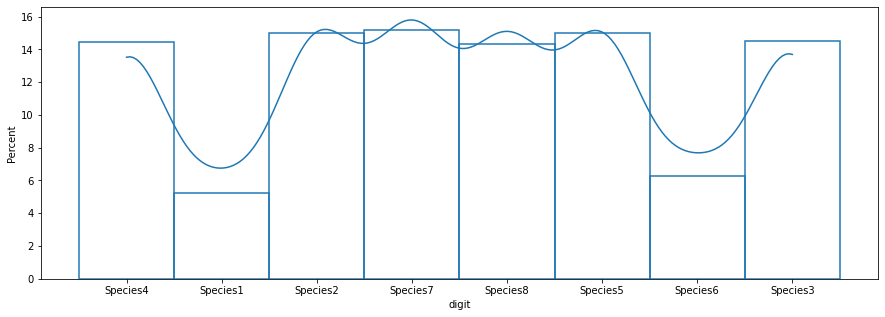

Counting occurrences of target classes:
Species7    537
Species2    532
Species5    531
Species3    515
Species4    511
Species8    508
Species6    222
Species1    186
Name: digit, dtype: int64


In [ ]:
#target
target_dict = {k: v for v, k in enumerate(np.unique(classes))}
target_val = [target_dict[classes[i]] for i in range(len(classes))]
print(target_dict)

# Convert the label to categorical
y = tfk.utils.to_categorical(target_val)

# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(classes, columns=['digit']), x='digit', stat="percent", element="bars", fill=False, kde=True)
plt.show()

print('Counting occurrences of target classes:')
print(pd.DataFrame(classes, columns=['digit'])['digit'].value_counts())

In [ ]:
from tensorflow.python.ops.control_flow_ops import switch
##CREATION OF TRAIN, VAL, TEST FOLDERS

# Split in train + validation and test
x_train_val, x_test, y_train_val, y_test = train_test_split(image_data, y, random_state=seed, test_size=.15)
print('train + val size: ',  x_train_val.shape, y_train_val.shape, '\ntest size: ', x_test.shape, y_test.shape)

# Split in train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size=.15, stratify=y_train_val)
print('train size: ', x_train.shape, y_train.shape, '\nval size: ', x_val.shape, y_val.shape)


train + val size:  (3010, 96, 96, 3) (3010, 8) 
test size:  (532, 96, 96, 3) (532, 8)
train size:  (2558, 96, 96, 3) (2558, 8) 
val size:  (452, 96, 96, 3) (452, 8)


In [ ]:
# Data Augmentation

t_array = []
y_array = []
i = 0

for image in x_train:

    value = random.randint(1,4)

    if value == 1:
        # Translation
        t = np.array(translate(image, 10, random.choice(['up', 'down', 'left', 'right'])))
        t_array.append(t)
        y_array.append(y[i])

    elif value == 2:
        # Rotation
        t = np.array(rotate_img(image, random.randint(10,60)))
        t_array.append(t)
        y_array.append(y[i])


    elif value == 3:
        # Gaussian Noise
        t = np.array(gaussian_noise(image))
        t_array.append(t)
        y_array.append(y[i])


    else:
        # Channel ratio
        t = np.array(change_channel_ratio(image))
        t_array.append(t)
        y_array.append(y[i])

    '''
    if y_array[i][0] == 1:

        # Translation
        t = np.array(translate(image, 10, random.choice(['up', 'down', 'left', 'right'])))
        t_array.append(t)
        y_array.append(y[i])
        # Rotation
        t = np.array(rotate_img(image, random.randint(10,60)))
        t_array.append(t)
        y_array.append(y[i])
        # Gaussian Noise
        t = np.array(gaussian_noise(image))
        t_array.append(t)
        y_array.append(y[i])
        # Channel ratio
        t = np.array(change_channel_ratio(image))
        t_array.append(t)
        y_array.append(y[i])
'''

    '''
    # Distortion
    t = np.array(distort(image))
    t_array.append(t)
    y_array.append(y[i])
    '''

    i = i + 1

In [ ]:
t_array = np.array(t_array)
y_array = np.array(y_array)
t_array.reshape((len(t_array), 96, 96, 3))
y_array.reshape((len(y_array), 8))

x_train = np.concatenate([x_train, t_array])
y_train = np.concatenate([y_train, y_array])

print(x_train.shape, y_train.shape)

(5116, 96, 96, 3) (5116, 8)


# **Normal CNN**

**Second model idea: add Resizing and replace Flatten with GlobalAveragePooling**

The idea of Resizing is to try the same case of all exercises seen in the exercise sessions, wherein input images usually had 64x64x3 shape. The idea of replacing Flatten with GlobalAveragePooling stems from the different ways the two functions work: the former squeezes the whole layer into one dimension, the latter computes the average of all values of the layer according to the last axis. Because of this, Flatten will always have at least as many parameters as GlobalAveragePooling, hence this choice aims to reduce the number of parameters in the network. For the same reason, one convolutional layer is removed, reducing the quantity from 5 to 4.

In [ ]:
'''# This function builds the NN architecture analyzing the inputted image
def build_second_model(input_shape):
    tf.random.set_seed(seed)
    l_lambda = 5e-5

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #resizing_layer = tfkl.Resizing(64, 64, name='resizing_layer')(input_layer)

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        #kernel_regularizer=tf.keras.regularizers.l1(l_lambda)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tf.keras.regularizers.L1L2(l_lambda, l_lambda)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        #kernel_regularizer=tf.keras.regularizers.l1(l_lambda)
    )(pool2)
    drop3 = tfkl.Dropout(0.3)(conv3)
    pool3 = tfkl.MaxPooling2D()(drop3)

    gap = tfkl.GlobalAveragePooling2D()(pool3)
    dropout = tfkl.Dropout(0.5, seed=seed)(gap)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(gap)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model'''

In [ ]:
'''second_model = build_second_model(input_shape)
second_model.summary()'''

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         

                                                                 

 conv2d_51 (Conv2D)          (None, 96, 96, 32)        896       

                                                                 

 max_pooling2d_51 (MaxPoolin  (None, 48, 48, 32)       0         

 g2D)                                                            

                                                                 

 conv2d_52 (Conv2D)          (None, 48, 48, 64)        18496     

                                                                 

 max_pooling2d_52 (MaxPoolin  (None, 24, 24, 64)       0         

 g2D)                                                            

                                                                 

 conv2d_53 (Conv2D)          (None, 24, 24, 1

In [ ]:
'''batch_size = 256
patience = 20
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)'''

In [ ]:
'''#fit with early stopping
history = second_model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 500,
    validation_data = (x_val, y_val),
    callbacks =  [early_stopping]
).history'''

Epoch 1/500

30/30 [==============================] - 5s 129ms/step - loss: 1.1128 - accuracy: 0.6048 - val_loss: 0.8802 - val_accuracy: 0.7235

Epoch 2/500

30/30 [==============================] - 3s 91ms/step - loss: 1.0870 - accuracy: 0.6190 - val_loss: 0.8650 - val_accuracy: 0.7389

Epoch 3/500

30/30 [==============================] - 3s 86ms/step - loss: 1.0806 - accuracy: 0.6230 - val_loss: 0.8816 - val_accuracy: 0.7323

Epoch 4/500

30/30 [==============================] - 3s 86ms/step - loss: 1.0818 - accuracy: 0.6178 - val_loss: 0.8817 - val_accuracy: 0.7168

Epoch 5/500

30/30 [==============================] - 3s 86ms/step - loss: 1.0817 - accuracy: 0.6174 - val_loss: 0.8810 - val_accuracy: 0.7168

Epoch 6/500

30/30 [==============================] - 3s 86ms/step - loss: 1.0787 - accuracy: 0.6199 - val_loss: 0.8727 - val_accuracy: 0.7257

Epoch 7/500

30/30 [==============================] - 3s 85ms/step - loss: 1.0776 - accuracy: 0.6178 - val_loss: 0.8853 - val_accuracy:

In [ ]:
'''import matplotlib.pyplot as plt

def plot_training(history):
    # Plot the training
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff0f9e')
    plt.legend(loc='upper left')
    plt.title('Loss function: categorical crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff0f9e')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()'''

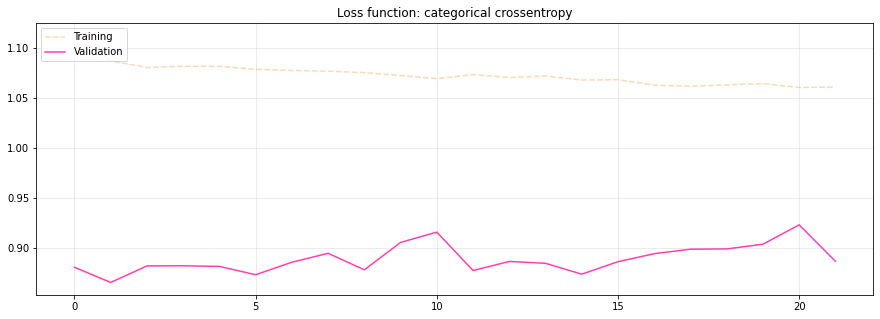

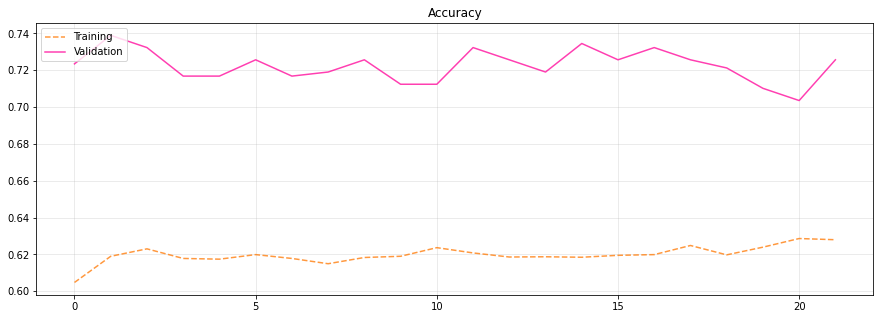

In [ ]:
'''plot_training(history)'''

Let's now see how the network performs for each class in the classification task. The tool for this purpose is the confusion matrix.

In [ ]:
'''# Predict the test set with the CNN
predictions = second_model.predict(x_test)

def plot_confusion_matrix():

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

plot_confusion_matrix()'''

In [ ]:
'''second_model.save('SubmissionModel')'''

In [ ]:
'''svm_model.save('kaggle/working/SubmissionModel')'''

In [ ]:
'''model_test_metrics = model.evaluate(test_gen, return_dict=True)

print("Test metrics with data augmentation")
print(model_test_metrics)'''

46/46 [==============================] - 1s 20ms/step - loss: 0.1698 - accuracy: 0.9945
Test metrics with data augmentation
{'loss': 0.1697525680065155, 'accuracy': 0.9944751262664795}


In [ ]:
'''from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))'''

Confusion Matrix
[[20  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  0]
 [ 0  0  0 52  0  0  0  0]
 [ 0  0  0  2 52  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 55  0]
 [ 0  0  0  0  0  0  0 52]]
Classification Report
              precision    recall  f1-score   support

    Species1       1.00      1.00      1.00        20
    Species2       1.00      1.00      1.00        54
    Species3       1.00      1.00      1.00        52
    Species4       0.96      1.00      0.98        52
    Species5       1.00      0.96      0.98        54
    Species6       1.00      1.00      1.00        23
    Species7       1.00      1.00      1.00        55
    Species8       1.00      1.00      1.00        52

    accuracy                           0.99       362
   macro avg       1.00      1.00      1.00       362
weighted avg       0.99      0.99      0.99       362



MSE
Mean: 0.7574; STD: 0.0331


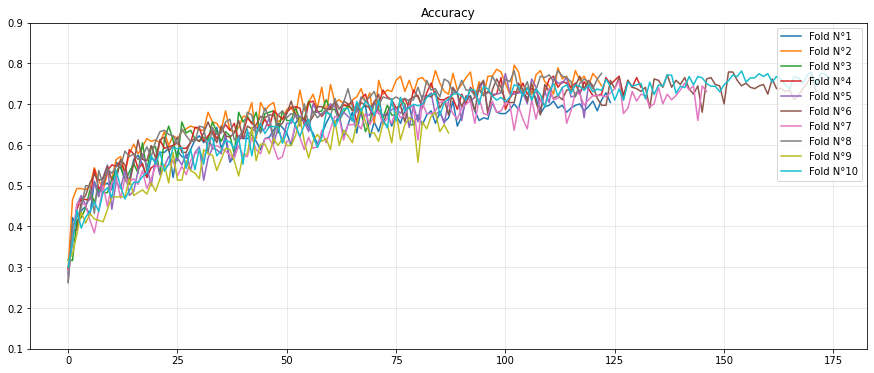

In [ ]:
'''
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("MSE")
print("Mean: {}; STD: {}".format(np.mean(scores).round(4), np.std(scores).round(4)))

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'], color=colors[fold_idx], label='Fold N°{}'.format(fold_idx+1))
  plt.ylim(0.1, 0.9)
  plt.title('Accuracy')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)
plt.show()
'''

In [ ]:
'''
class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):

        # Normalize data
        X = np.array(X)
        X = X.astype('float32')
        X = X/255.

        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)

        return out
        '''

In [ ]:
'''from IPython.display import FileLink

%cd
%cd ..
%cd kaggle/working
%ls
FileLink(r'SubmissionModel')'''

/root
/
/kaggle/working
SubmissionModel/  __notebook_source__.ipynb  splitted/


ValueError: Cannot display a directory using FileLink. Use FileLinks to display 'SubmissionModel'.

In [ ]:
'''
%cd /kaggle/working
'''

/kaggle/working


In [ ]:
'''
<a href=""> Download File </a>
'''

SubmissionModel/  __notebook_source__.ipynb


# **Transfer Learning**

In [ ]:
'''# Apply same preprocessing used to train the supernet
from tensorflow.keras.applications.vgg16 import preprocess_input

x_train_ft = preprocess_input(x_train*255)
x_val_ft = preprocess_input(x_val*255)
x_test_tf = preprocess_input(x_test*255)'''

In [ ]:
'''# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3)
)
supernet.summary()
# tfk.utils.plot_model(supernet)'''

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
'''# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()'''

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         

                                                                 

 resizing (Resizing)         (None, 64, 64, 3)         0         

                                                                 

 vgg16 (Functional)          (None, 2, 2, 512)         14714688  

                                                                 

 Flattening (Flatten)        (None, 2048)              0         

                                                                 

 dropout (Dropout)           (None, 2048)              0         

                                                                 

 dense (Dense)               (None, 256)               524544    

                                                                 

 dropout_1 (Dropout)         (None, 256)     

In [ ]:
'''# Train the model
tl_history = tl_model.fit(
    x = x_train_ft,
    y = y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (x_val_ft, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history'''

Epoch 1/200

 6/40 [===>..........................] - ETA: 6:30 - loss: 15.2257 - accuracy: 0.1829

KeyboardInterrupt: ignored

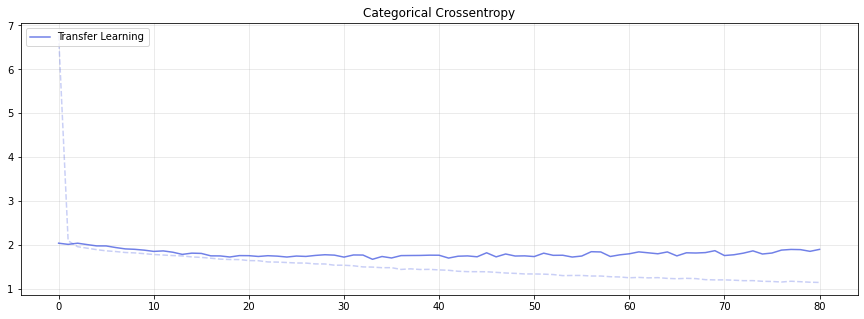

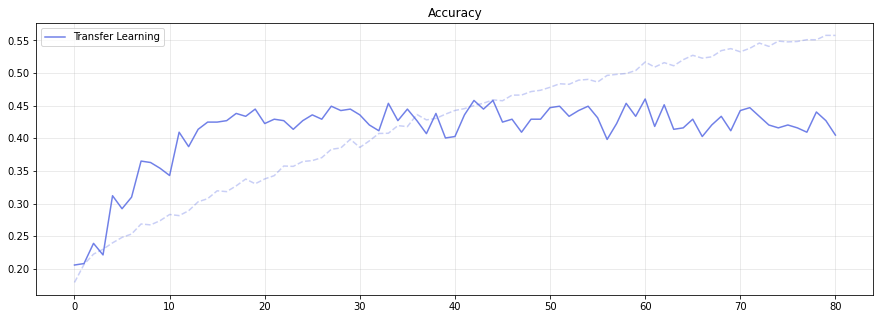

In [ ]:
'''# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()'''

17/17 [==============================] - 1s 43ms/step

Accuracy: 0.4624

Precision: 0.4623

Recall: 0.3981

F1: 0.3721


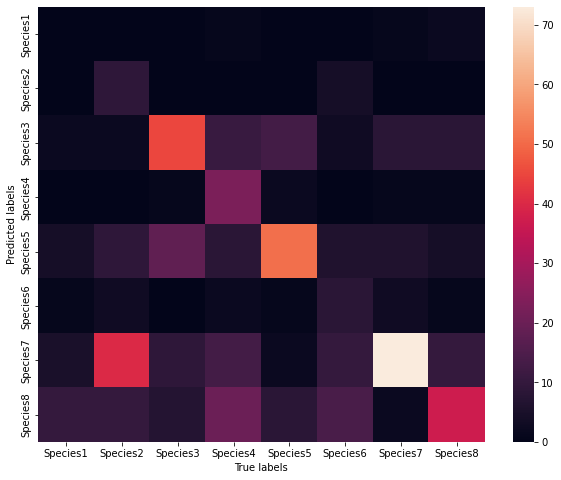

In [ ]:
'''# Predict the test set with the CNN
predictions = tl_model.predict(x_test_tf)

def plot_confusion_matrix():

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

plot_confusion_matrix()'''

**Fine Tuning**

In [ ]:
'''# Set all VGG layers to True
ft_model = tl_model
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)'''

In [ ]:
'''# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')'''

In [ ]:
'''# Fine-tune the model
ft_history = ft_model.fit(
    x = x_train_ft,
    y = y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (x_val_ft, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history'''

In [ ]:
'''# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()'''

In [ ]:
'''# Predict the test set with the CNN
predictions = ft_model.predict(x_test_tf)

def plot_confusion_matrix():

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

plot_confusion_matrix()'''

# **Data augmentation, Transfer Learning and Fine Tuning Xception**

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders as sf

input_dir = './kaggle/input/training-dataset-homework1/training_data_final'
output_dir = './kaggle/working/splitted'

sf.ratio(input_dir, output=output_dir, seed=seed, ratio=(0.8, 0.1, 0.1))

train_dir = "./kaggle/working/splitted/train"
val_dir = "./kaggle/working/splitted/val"
test_dir = "./kaggle/working/splitted/test"

Copying files: 3542 files [00:03, 1008.51 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    rescale=1./255
)

val_test_data_gen = ImageDataGenerator(
    rescale=1./255
)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = val_test_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = val_test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

**Normal**

In [ ]:
# Download and plot the Exception model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(192,192,3),
    classes=8
)
supernet.summary()
# tfk.utils.plot_model(supernet)

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False
learning_rate = 1e-4

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(192, 192, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 73728)             0         
_________________________________________________________________
dropout (Dropout)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               18874624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

**With Fine Tuning**

In [ ]:
# Download and plot the Xception model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(192,192,3),
    classes=8
)

supernet.trainable = False

'''
supernet.trainable = True
for layer in supernet.layers[:32]:
    layer.trainable = False
'''

'\nsupernet.trainable = True\nfor layer in supernet.layers[:32]:\n    layer.trainable = False\n'

In [ ]:
def build_tl_model(input_shape):
    inputs = tfkl.Input(shape=input_shape)
    x = tfkl.Resizing(192,192)(inputs)
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D()(x)
    #x = tfkl.Dropout(0.5, seed=seed)(x)
    x = tfkl.Dense(
          256,
          activation='relu',
          kernel_initializer = tfk.initializers.HeUniform(seed),
          kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    outputs = tfkl.Dense(
          8,
          activation='softmax',
          kernel_initializer = tfk.initializers.GlorotUniform(seed),
          kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))(x)


    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
    round(tl_model.optimizer.lr.numpy(), 5)

    return tl_model

In [ ]:
tl_model = build_tl_model(input_shape)
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056  

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('./data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))

    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)


    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch

    callbacks.append(ckpt_callback)


    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)

    # Learning rate scheduler
    #------------------------
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks.append(lr_callback)

    return callbacks

In [ ]:
'''# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = tl_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history'''

Epoch 1/200
354/354 [==============================] - 28s 46ms/step - loss: 1.8479 - accuracy: 0.3574 - val_loss: 1.5845 - val_accuracy: 0.4701
Epoch 2/200
354/354 [==============================] - 14s 40ms/step - loss: 1.5798 - accuracy: 0.4517 - val_loss: 1.3946 - val_accuracy: 0.5271
Epoch 3/200
354/354 [==============================] - 14s 39ms/step - loss: 1.4737 - accuracy: 0.4928 - val_loss: 1.3047 - val_accuracy: 0.5726
Epoch 4/200
354/354 [==============================] - 15s 41ms/step - loss: 1.4309 - accuracy: 0.5051 - val_loss: 1.2684 - val_accuracy: 0.5641
Epoch 5/200
354/354 [==============================] - 14s 41ms/step - loss: 1.3810 - accuracy: 0.5253 - val_loss: 1.2221 - val_accuracy: 0.5926
Epoch 6/200
354/354 [==============================] - 15s 42ms/step - loss: 1.3538 - accuracy: 0.5355 - val_loss: 1.2113 - val_accuracy: 0.5755
Epoch 7/200
354/354 [==============================] - 14s 40ms/step - loss: 1.3219 - accuracy: 0.5574 - val_loss: 1.1758 - val_ac

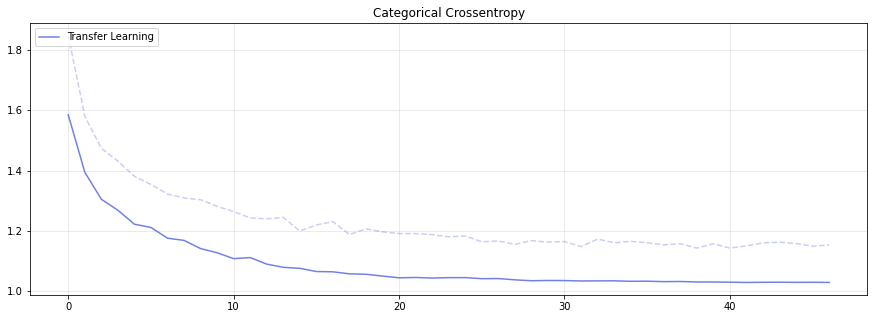

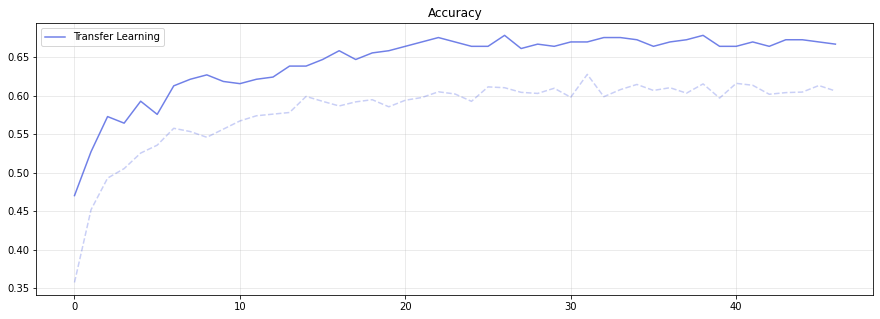

In [ ]:
'''# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()'''

In [ ]:
'''# Test with data augmentation

model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print("Test metrics with data augmentation")
print(model_test_metrics)'''

46/46 [==============================] - 1s 29ms/step - loss: 1.1348 - accuracy: 0.6298
Test metrics with data augmentation
{'loss': 1.134772777557373, 'accuracy': 0.6298342347145081}


In [ ]:
'''#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = tl_model.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))'''

Confusion Matrix

[[ 5  5  0  3  0  0  2  5]

 [ 2 30  2  5  1  1 10  3]

 [ 0  0 43  1  6  0  1  1]

 [ 0  2  4 31  7  1  5  2]

 [ 0  0 10  9 33  0  0  2]

 [ 0  7  0  1  0 12  1  2]

 [ 0 10  4  1  1  0 39  0]

 [ 1  5  1  4  3  0  7 31]]

Classification Report

              precision    recall  f1-score   support



    Species1       0.62      0.25      0.36        20

    Species2       0.51      0.56      0.53        54

    Species3       0.67      0.83      0.74        52

    Species4       0.56      0.60      0.58        52

    Species5       0.65      0.61      0.63        54

    Species6       0.86      0.52      0.65        23

    Species7       0.60      0.71      0.65        55

    Species8       0.67      0.60      0.63        52



    accuracy                           0.62       362

   macro avg       0.64      0.58      0.60       362

weighted avg       0.63      0.62      0.61       362




In [ ]:
'''tl_model.save("SubmissionModel")'''

In [ ]:
ft_model = tl_model

supernet.trainable = True
for layer in supernet.layers[:32]:
    layer.trainable = False

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
ft_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056  

In [ ]:
'''# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_ft')

# Train the model
history_ft = ft_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history'''

Epoch 1/200
354/354 [==============================] - 30s 54ms/step - loss: 1.5346 - accuracy: 0.4733 - val_loss: 1.1913 - val_accuracy: 0.6325
Epoch 2/200
354/354 [==============================] - 19s 53ms/step - loss: 1.1708 - accuracy: 0.6030 - val_loss: 0.8640 - val_accuracy: 0.7208
Epoch 3/200
354/354 [==============================] - 18s 50ms/step - loss: 1.0314 - accuracy: 0.6628 - val_loss: 0.7899 - val_accuracy: 0.7550
Epoch 4/200
354/354 [==============================] - 18s 50ms/step - loss: 0.9470 - accuracy: 0.6921 - val_loss: 0.7743 - val_accuracy: 0.7749
Epoch 5/200
354/354 [==============================] - 18s 52ms/step - loss: 0.8916 - accuracy: 0.7193 - val_loss: 0.7736 - val_accuracy: 0.7293
Epoch 6/200
354/354 [==============================] - 18s 51ms/step - loss: 0.8526 - accuracy: 0.7349 - val_loss: 0.7447 - val_accuracy: 0.7863
Epoch 7/200
354/354 [==============================] - 18s 51ms/step - loss: 0.8088 - accuracy: 0.7416 - val_loss: 0.7244 - val_ac

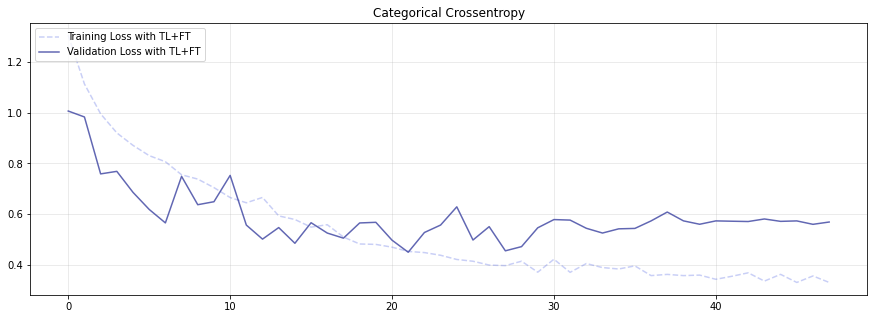

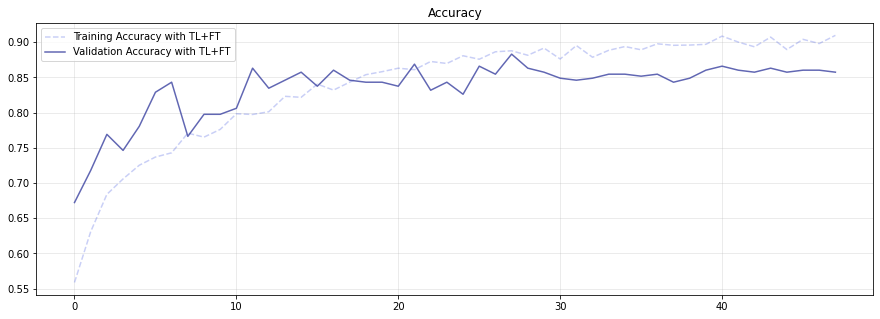

In [ ]:
'''# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_ft['loss'], label='Training Loss with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_ft['val_loss'], label='Validation Loss with TL+FT', alpha=.8, color='#3A41A0')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_ft['accuracy'], label='Training Accuracy with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_ft['val_accuracy'], label='Validation Accuracy with TL+FT', alpha=.8, color='#3A41A0')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()'''

In [ ]:
'''# Test with fine tuning

model_test_metrics = ft_model.evaluate(test_gen, return_dict=True)

print("Test metrics with data augmentation")
print(model_test_metrics)'''

46/46 [==============================] - 1s 19ms/step - loss: 0.5534 - accuracy: 0.8591
Test metrics with data augmentation
{'loss': 0.5533747673034668, 'accuracy': 0.8591160178184509}


In [ ]:
'''#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = ft_model.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))'''

Confusion Matrix
[[11  2  0  2  0  0  1  4]
 [ 0 45  0  1  1  0  2  5]
 [ 0  1 47  2  2  0  0  0]
 [ 0  0  0 46  5  0  0  1]
 [ 0  0  4  5 44  0  0  1]
 [ 0  1  0  1  0 19  0  2]
 [ 0  1  0  0  0  1 53  0]
 [ 1  2  0  1  1  0  1 46]]
Classification Report
              precision    recall  f1-score   support

    Species1       0.92      0.55      0.69        20
    Species2       0.87      0.83      0.85        54
    Species3       0.92      0.90      0.91        52
    Species4       0.79      0.88      0.84        52
    Species5       0.83      0.81      0.82        54
    Species6       0.95      0.83      0.88        23
    Species7       0.93      0.96      0.95        55
    Species8       0.78      0.88      0.83        52

    accuracy                           0.86       362
   macro avg       0.87      0.83      0.85       362
weighted avg       0.86      0.86      0.86       362



In [ ]:
'''ft_model.save("kaggle/working/SubmissionModelXceptionFT")'''

# **Quasi-SVM**

In [ ]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def build_svm_model(input_shape):
    svm_model = tfk.Sequential(
        [
            tfkl.Input(shape=input_shape),
            tfkl.Resizing(192,192),
            supernet,
            tfkl.GlobalAveragePooling2D(),
            tfkl.Dense(units = 512,
                       activation = 'relu',
                       kernel_initializer = tfk.initializers.HeUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6)),
            # Quasi-SVM part
            RandomFourierFeatures(
                output_dim=4096, scale=10.0, kernel_initializer="gaussian"
            ),
            tfkl.Dropout(0.3),
            tfkl.Dense(units=8,
                       activation='softmax',
                       kernel_initializer = tfk.initializers.GlorotUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))
        ]
    )

    svm_model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=[tfk.metrics.CategoricalAccuracy("accuracy")],
    )

    return svm_model

In [ ]:
svm_model = build_svm_model(input_shape)
svm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
random_fourier_features (Ran (None, 4096)              2101249   
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 3

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_ft')

# Train the model
history_svm = svm_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
354/354 [==============================] - 32s 78ms/step - loss: 0.8655 - accuracy: 0.7635 - val_loss: 0.5107 - val_accuracy: 0.8889
Epoch 2/200
354/354 [==============================] - 27s 76ms/step - loss: 0.7000 - accuracy: 0.8183 - val_loss: 0.6110 - val_accuracy: 0.8490
Epoch 3/200
354/354 [==============================] - 27s 75ms/step - loss: 0.6964 - accuracy: 0.8158 - val_loss: 0.7609 - val_accuracy: 0.8234
Epoch 4/200
354/354 [==============================] - 27s 77ms/step - loss: 0.6565 - accuracy: 0.8286 - val_loss: 0.5935 - val_accuracy: 0.8618
Epoch 5/200
354/354 [==============================] - 27s 76ms/step - loss: 0.6663 - accuracy: 0.8233 - val_loss: 0.6043 - val_accuracy: 0.8575
Epoch 6/200
354/354 [==============================] - 27s 77ms/step - loss: 0.6243 - accuracy: 0.8399 - val_loss: 0.7378 - val_accuracy: 0.8276
Epoch 7/200
354/354 [==============================] - 27s 76ms/step - loss: 0.6289 - accuracy: 0.8370 - val_loss: 0.6206 - val_ac

In [ ]:
svm_model_test_metrics = svm_model.evaluate(test_gen, return_dict=True)

print("Test metrics with data augmentation")
print(svm_model_test_metrics)

90/90 [==============================] - 3s 28ms/step - loss: 0.8398 - accuracy: 0.8436
Test metrics with data augmentation
{'loss': 0.8397830724716187, 'accuracy': 0.8435754179954529}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = svm_model.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))

Confusion Matrix
[[ 12   9   0   3   1   1   1  11]
 [  0  98   1   2   1   0   1   4]
 [  0   0  82   3  19   0   0   0]
 [  0   1   0  98   3   0   0   1]
 [  0   0   3   8  95   0   0   1]
 [  0   6   0   3   0  32   1   3]
 [  0   2   0   1   1   0 105   0]
 [  4   7   0   6   1   0   3  82]]
Classification Report
              precision    recall  f1-score   support

    Species1       0.75      0.32      0.44        38
    Species2       0.80      0.92      0.85       107
    Species3       0.95      0.79      0.86       104
    Species4       0.79      0.95      0.86       103
    Species5       0.79      0.89      0.83       107
    Species6       0.97      0.71      0.82        45
    Species7       0.95      0.96      0.95       109
    Species8       0.80      0.80      0.80       103

    accuracy                           0.84       716
   macro avg       0.85      0.79      0.80       716
weighted avg       0.85      0.84      0.84       716



In [ ]:
svm_model.save('kaggle/working/SubmissionModelSVMNoTrainable')

**Train also Quasi-SVM**

In [ ]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def build_svm_model_with_trainable_weights(input_shape):
    svm_model = tfk.Sequential(
        [
            tfkl.Input(shape=input_shape),
            tfkl.Resizing(192,192),
            supernet,
            tfkl.GlobalAveragePooling2D(),
            tfkl.Dense(units = 512,
                       activation = 'relu',
                       kernel_initializer = tfk.initializers.HeUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6)),
            # Quasi-SVM part
            RandomFourierFeatures(
                output_dim=4096, scale=10.0, kernel_initializer="gaussian", trainable=True
            ),
            tfkl.Dropout(0.3),
            tfkl.Dense(units=8,
                       activation='softmax',
                       kernel_initializer = tfk.initializers.GlorotUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))
        ]
    )

    svm_model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=[tfk.metrics.CategoricalAccuracy("accuracy")],
    )

    return svm_model

svm_model_t = build_svm_model_with_trainable_weights(input_shape)

In [ ]:
svm_model_t.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
random_fourier_features_1 (R (None, 4096)              2101249   
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

In [ ]:
train_gen

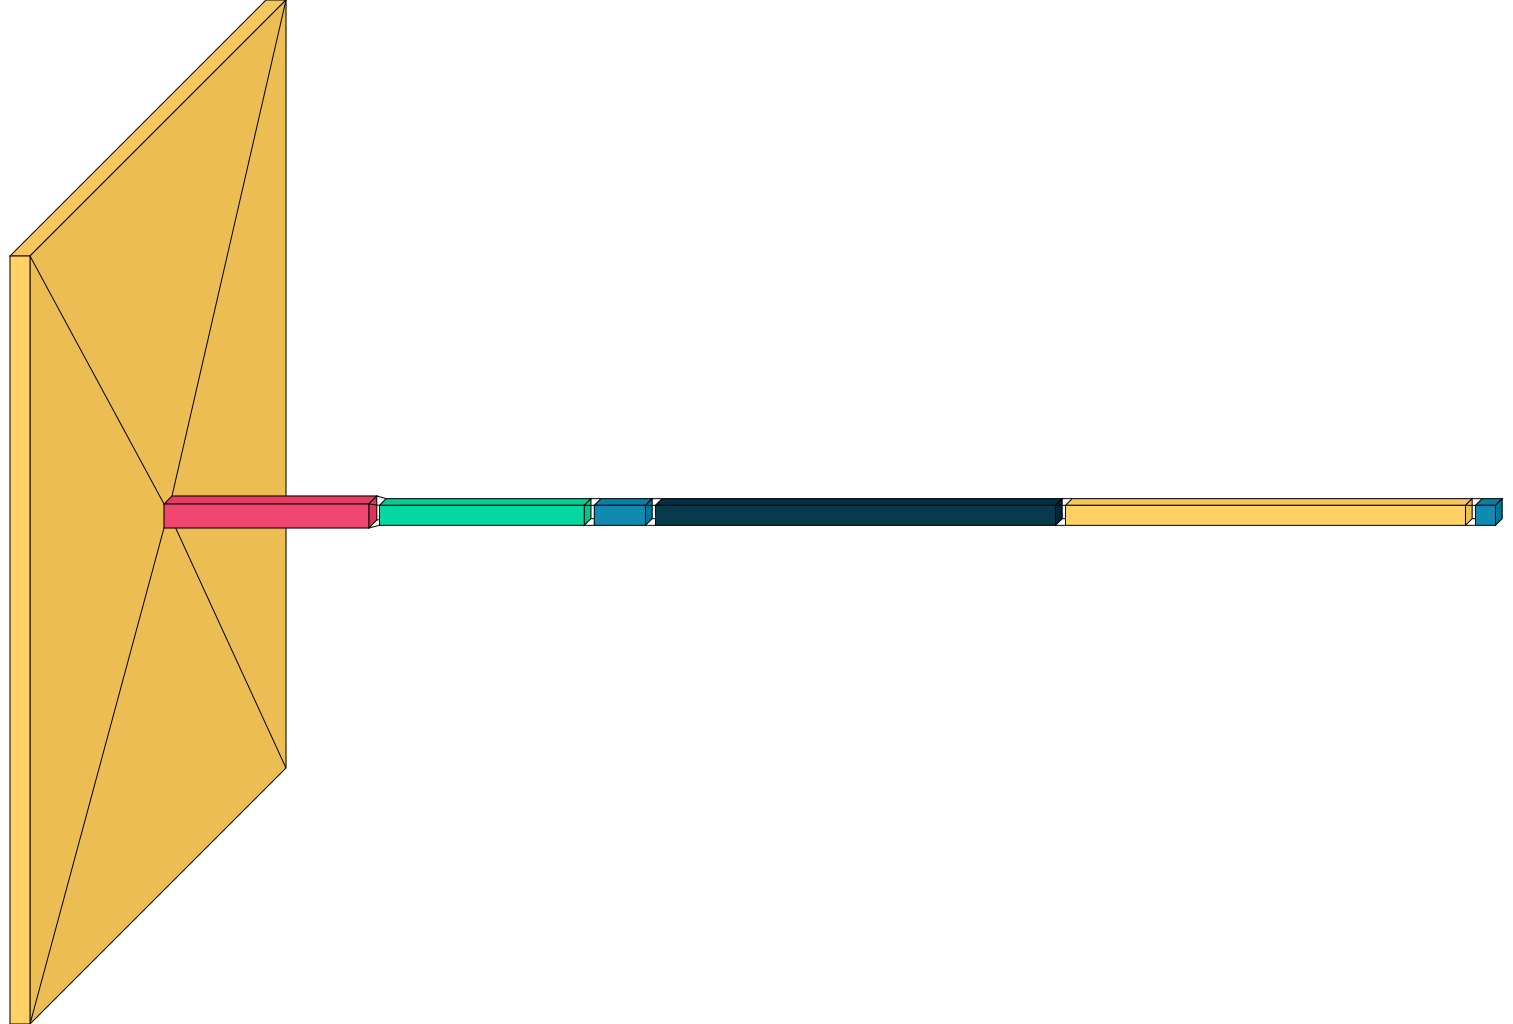

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(svm_model_t)

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_SVM_trained_weights')

# Train the model
history_svm_trainable = svm_model_t.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
354/354 [==============================] - 41s 78ms/step - loss: 1.8068 - accuracy: 0.3941 - val_loss: 1.1528 - val_accuracy: 0.6296
Epoch 2/200
354/354 [==============================] - 26s 73ms/step - loss: 1.3633 - accuracy: 0.5769 - val_loss: 1.0888 - val_accuracy: 0.7094
Epoch 3/200
354/354 [==============================] - 26s 75ms/step - loss: 1.2096 - accuracy: 0.6313 - val_loss: 0.9353 - val_accuracy: 0.7436
Epoch 4/200
354/354 [==============================] - 27s 76ms/step - loss: 1.1509 - accuracy: 0.6592 - val_loss: 0.8297 - val_accuracy: 0.7749
Epoch 5/200
354/354 [==============================] - 27s 76ms/step - loss: 1.0518 - accuracy: 0.6886 - val_loss: 0.9691 - val_accuracy: 0.7236
Epoch 6/200
354/354 [==============================] - 27s 77ms/step - loss: 1.0188 - accuracy: 0.7045 - val_loss: 0.8644 - val_accuracy: 0.7778
Epoch 7/200
354/354 [==============================] - 27s 77ms/step - loss: 0.9439 - accuracy: 0.7282 - val_loss: 0.8763 - val_ac

In [ ]:
def plot_performance(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='Training Loss with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
    plt.plot(history['val_loss'], label='Validation Loss with TL+FT', alpha=.8, color='#3A41A0')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='Training Accuracy with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
    plt.plot(history['val_accuracy'], label='Validation Accuracy with TL+FT', alpha=.8, color='#3A41A0')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

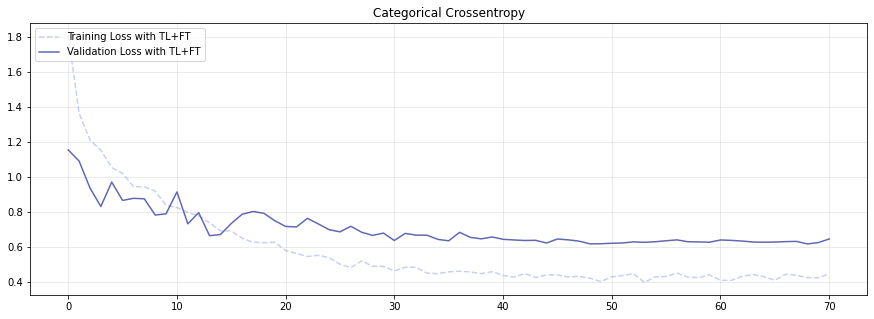

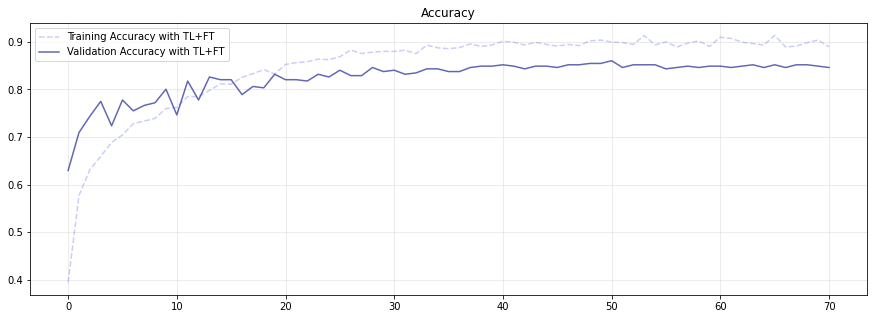

In [ ]:
plot_performance(history_svm_trainable)

In [ ]:
svm_model_test_metrics_trainable = svm_model_t.evaluate(test_gen, callbacks=aug_callbacks, return_dict=True)

print("Test metrics with data augmentation")
print(svm_model_test_metrics_trainable)

46/46 [==============================] - 2s 39ms/step - loss: 0.5925 - accuracy: 0.8536
Test metrics with data augmentation
{'loss': 0.5925384163856506, 'accuracy': 0.8535911440849304}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = svm_model_t.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))

<class 'numpy.ndarray'>
Confusion Matrix
[[ 7  3  0  1  0  0  1  8]
 [ 0 49  0  0  0  0  2  3]
 [ 0  0 42  2  8  0  0  0]
 [ 0  0  0 48  2  0  0  2]
 [ 0  1  3  2 47  0  0  1]
 [ 0  3  0  1  0 19  0  0]
 [ 0  3  0  0  0  0 52  0]
 [ 1  2  0  2  1  0  1 45]]
Classification Report
              precision    recall  f1-score   support

    Species1       0.88      0.35      0.50        20
    Species2       0.80      0.91      0.85        54
    Species3       0.93      0.81      0.87        52
    Species4       0.86      0.92      0.89        52
    Species5       0.81      0.87      0.84        54
    Species6       1.00      0.83      0.90        23
    Species7       0.93      0.95      0.94        55
    Species8       0.76      0.87      0.81        52

    accuracy                           0.85       362
   macro avg       0.87      0.81      0.82       362
weighted avg       0.86      0.85      0.85       362



In [ ]:
svm_model.save('kaggle/working/SubmissionModelSVMTrainable')

# **Ensemble techniques**

In [ ]:
def build_ensemble_model(input_shape, n_learners):

    ensemble_model = [0] * n_learners

    for j in range(n_learners):
        ensemble_model[j] = tfk.Sequential([
            tfkl.Input(shape=input_shape),
            tfkl.Resizing(192,192),
            supernet,
            tfkl.GlobalAveragePooling2D(),
            tfkl.Dense(units = 512,
                       activation = 'relu',
                       kernel_initializer = tfk.initializers.HeUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6)),
            # Quasi-SVM part
            RandomFourierFeatures(
                output_dim=4096, scale=10.0, kernel_initializer="gaussian", trainable=True
            ),
            tfkl.Dropout(0.3),
            tfkl.Dense(units=8,
                       activation='softmax',
                       kernel_initializer = tfk.initializers.GlorotUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))
        ])

        ensemble_model[j].compile(
            optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
            loss=tfk.losses.CategoricalCrossentropy(),
            metrics=[tfk.metrics.CategoricalAccuracy("accuracy")],
        )

    model = [ensemble_model[j] for j in range(len(ensemble_model))]
    model_input = tfkl.Input(input_shape)
    model_outputs = [m(model_input) for m in model]
    ensemble_output = tfkl.Average()(model_outputs)
    final_model = tfk.models.Model(inputs=model_input, outputs=ensemble_output)

    final_model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=[tfk.metrics.CategoricalAccuracy("accuracy")],
    )

    return final_model

In [ ]:
n_learners = 5
ensemble_model = build_ensemble_model(input_shape, n_learners)
ensemble_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 8)            24044593    input_21[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8)            24044593    input_21[0][0]                   
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 8)            24044593    input_21[0][0]                   
____________________________________________________________________________________________

In [ ]:
aug_callbacks = lderslders_and_callbacks(model_name='CNN_Aug_SVM_ensemble')

# Train each submodel
history_ensemble = ensemble_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
354/354 [==============================] - 142s 358ms/step - loss: 2.3106 - accuracy: 0.4139 - val_loss: 1.8470 - val_accuracy: 0.6353
Epoch 2/200
354/354 [==============================] - 125s 353ms/step - loss: 1.9006 - accuracy: 0.5832 - val_loss: 1.6441 - val_accuracy: 0.7094
Epoch 3/200
354/354 [==============================] - 125s 352ms/step - loss: 1.7351 - accuracy: 0.6603 - val_loss: 1.5273 - val_accuracy: 0.7407
Epoch 4/200
354/354 [==============================] - 125s 352ms/step - loss: 1.6842 - accuracy: 0.6790 - val_loss: 1.4274 - val_accuracy: 0.7436
Epoch 5/200
354/354 [==============================] - 124s 352ms/step - loss: 1.5686 - accuracy: 0.7154 - val_loss: 1.4750 - val_accuracy: 0.7350
Epoch 6/200
354/354 [==============================] - 125s 352ms/step - loss: 1.5324 - accuracy: 0.7158 - val_loss: 1.5226 - val_accuracy: 0.7236
Epoch 7/200
354/354 [==============================] - 124s 351ms/step - loss: 1.4654 - accuracy: 0.7434 - val_loss: 1

In [ ]:
ensemble_model_test_metrics = ensemble_model.evaluate(test_gen, callbacks=aug_callbacks, return_dict=True)

print("Test metrics with data augmentation")
print(ensemble_model_test_metrics)

46/46 [==============================] - 6s 126ms/step - loss: 1.0663 - accuracy: 0.8398
Test metrics with data augmentation
{'loss': 1.066278338432312, 'accuracy': 0.8397790193557739}


In [ ]:
ensemble_model.save('kaggle/working/ensembleModel')

In [ ]:
!zip -r kaggle/working/ensembleModel kaggle/working/ensembleModel

updating: kaggle/working/ensembleModel/ (stored 0%)
updating: kaggle/working/ensembleModel/assets/ (stored 0%)
updating: kaggle/working/ensembleModel/variables/ (stored 0%)
updating: kaggle/working/ensembleModel/variables/variables.index (deflated 79%)
updating: kaggle/working/ensembleModel/variables/variables.data-00000-of-00001 (deflated 8%)
updating: kaggle/working/ensembleModel/saved_model.pb (deflated 92%)
updating: kaggle/working/ensembleModel/keras_metadata.pb (deflated 96%)


In [ ]:
# K-FOLD CROSS VALIDATION
from sklearn.model_selection import KFold

num_folds = 5

histories = []
scores = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

ensemble_model_KFold = ensemble_model

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(x_train_val, y_train_val)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    #model = build_svm_model(input_shape)

    history = ensemble_model_KFold.fit(
        x = x_train_val[train_idx],
        y = y_train_val[train_idx],
        validation_data=(x_train_val[valid_idx], y_train_val[valid_idx]),
        batch_size = 32,
        epochs = 200,
        callbacks=[create_folders_and_callbacks(model_name='CNN_Aug_SVM_KFold')]
    ).history

    score = ensemble_model_KFold.evaluate(x_train_val[valid_idx], y_train_val[valid_idx])
    scores.append(score[1])

    histories.append(history)

Starting training on fold num: 1
Epoch 1/200
76/76 [==============================] - 98s 1s/step - loss: 0.7504 - accuracy: 0.9473 - val_loss: 0.7459 - val_accuracy: 0.9352
Epoch 2/200
76/76 [==============================] - 98s 1s/step - loss: 0.7544 - accuracy: 0.9406 - val_loss: 0.7383 - val_accuracy: 0.9402
Epoch 3/200
76/76 [==============================] - 98s 1s/step - loss: 0.7357 - accuracy: 0.9576 - val_loss: 0.7366 - val_accuracy: 0.9452
Epoch 4/200
76/76 [==============================] - 98s 1s/step - loss: 0.7380 - accuracy: 0.9510 - val_loss: 0.7344 - val_accuracy: 0.9468
Epoch 5/200
76/76 [==============================] - 98s 1s/step - loss: 0.7285 - accuracy: 0.9518 - val_loss: 0.7346 - val_accuracy: 0.9435
Epoch 6/200
76/76 [==============================] - 98s 1s/step - loss: 0.7272 - accuracy: 0.9518 - val_loss: 0.7334 - val_accuracy: 0.9452
Epoch 7/200
76/76 [==============================] - 98s 1s/step - loss: 0.7108 - accuracy: 0.9605 - val_loss: 0.7296 - v

In [ ]:
ensemble_model_KFold.save('kaggle/working/EnsembleModelKFold')

In [ ]:
!zip -r kaggle/working/EnsembleModelKFold kaggle/working/EnsembleModelKFold

  adding: kaggle/working/EnsembleModelKFold/ (stored 0%)
  adding: kaggle/working/EnsembleModelKFold/assets/ (stored 0%)
  adding: kaggle/working/EnsembleModelKFold/variables/ (stored 0%)
  adding: kaggle/working/EnsembleModelKFold/variables/variables.index (deflated 79%)
  adding: kaggle/working/EnsembleModelKFold/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/EnsembleModelKFold/saved_model.pb (deflated 92%)
  adding: kaggle/working/EnsembleModelKFold/keras_metadata.pb (deflated 96%)
